## Bug Algorithm Comparison

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import sklearn.preprocessing
import os,re

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ping-dev04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Build data

In [3]:
data = pd.read_csv('idata.csv')

In [4]:
data.head()

,Bug ID,Product,Component,Summary
0,1436291.0,Firefox for Android,Activity Stream,"Context menu animation broken when ""Delete fro..."
1,1436379.0,Firefox for Android,Activity Stream,Links do not work when Pocket stories are upda...
2,1254660.0,Firefox for Android,Activity Stream,Don't list both http and https versions of a U...
3,1273667.0,Firefox for Android,Activity Stream,Simplify long-press context menu for top sites...
4,1299685.0,Firefox for Android,Activity Stream,Consider replacing ActivityStream topsites' Vi...


In [5]:
train = pd.DataFrame()
train['bugID'] = data['Bug ID']
train['text'] = data['Summary']

In [6]:
train.head()

,bugID,text
0,1436291.0,"Context menu animation broken when ""Delete fro..."
1,1436379.0,Links do not work when Pocket stories are upda...
2,1254660.0,Don't list both http and https versions of a U...
3,1273667.0,Simplify long-press context menu for top sites...
4,1299685.0,Consider replacing ActivityStream topsites' Vi...


--------------

### TFIDF Vectorization

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf_vectorizer = TfidfVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor=None,
                                   stop_words='english',
                                   max_features=None)
sparce_tfidf = tfidf_vectorizer.fit_transform(train['text'])

In [9]:
from sklearn.decomposition import TruncatedSVD

In [10]:
svd = TruncatedSVD(n_components=100, n_iter=25, random_state=12)
t_tfidf = svd.fit_transform(sparce_tfidf)

-----------------

## CLustering Comparison :
```'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
   'SpectralClustering', 'Ward', 'AgglomerativeClustering',
   'DBSCAN', 'Birch'```

In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [29]:
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [30]:
clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

In [31]:
X = t_tfidf

##### Normalize dataset for easier parameter selection

In [32]:
X = StandardScaler().fit_transform(X)

##### Estimate bandwidth for mean shift

In [33]:
bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

##### Connectivity matrix for structured Ward

In [34]:
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

##### Make connectivity symmetric

In [35]:
connectivity = 0.5 * (connectivity + connectivity.T)

--------------

#### Create clustering estimators

In [75]:

'''create MeanShift estimator'''
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)


'''create MinbatchKmeans estimator'''
two_means = cluster.MiniBatchKMeans(n_clusters=3)


'''create SpectralClustering estimator'''
spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")


'''create Agglo(ward) estimator'''
ward = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward',
                                           connectivity=connectivity)


'''create DBSCAN estimator'''
dbscan = cluster.DBSCAN(eps=.2)



'''create affinity propagation estimator'''
affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)


'''create birch estimator'''
average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=3,
        connectivity=connectivity)



'''create birch estimator'''
birch = cluster.Birch(n_clusters=3)



'''collect all algorithm to a algorithm list'''
clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]


In [78]:
Result = []
tmd =[]
for name, algorithm in zip(clustering_names, clustering_algorithms):
    
        # predict cluster memberships
        t0 = time.time()
       
       
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.fit_predict(X)
            
        t1 = time.time()    
        tm = t1-t0
        tmd.append({'name': name, 'time':tm})
       
        Result.append({name : y_pred})
        print(name,tm)


MiniBatchKMeans 4.124641418457031e-05
AffinityPropagation 107.98855400085449
MeanShift 1.1881823539733887


/home/ping-dev04/anaconda2/envs/GenomX/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering 19.888654470443726


/home/ping-dev04/anaconda2/envs/GenomX/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


Ward 1.5226407051086426


/home/ping-dev04/anaconda2/envs/GenomX/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)


AgglomerativeClustering 23.483237266540527
DBSCAN 0.8180196285247803
Birch 3.371689796447754


In [79]:
Result

[{'MiniBatchKMeans': array([2, 2, 0, ..., 2, 2, 2])},
 {'AffinityPropagation': array([ 37, 163,  19, ..., 122, 258, 258])},
 {'MeanShift': array([0, 0, 0, ..., 0, 0, 0])},
 {'SpectralClustering': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)},
 {'Ward': array([0, 0, 0, ..., 0, 0, 0])},
 {'AgglomerativeClustering': array([0, 0, 0, ..., 0, 0, 0])},
 {'DBSCAN': array([-1, -1, -1, ..., -1, -1, -1])},
 {'Birch': array([0, 0, 0, ..., 0, 0, 0])}]

In [80]:
df = pd.DataFrame()
for item in Result:
    df[list(item.keys())[0]] = list(item.values())[0]

In [81]:
df

,MiniBatchKMeans,AffinityPropagation,MeanShift,SpectralClustering,Ward,AgglomerativeClustering,DBSCAN,Birch
0,2,37,0,0,0,0,-1,0
1,2,163,0,0,0,0,-1,0
2,0,19,0,0,0,0,-1,0
3,2,242,0,0,0,0,-1,0
4,2,229,0,0,0,0,-1,0
5,2,30,0,0,0,0,-1,0
6,2,148,0,0,0,0,-1,0
7,2,86,0,0,0,0,-1,0
8,2,242,0,0,0,0,-1,0
9,2,64,0,0,0,0,-1,0


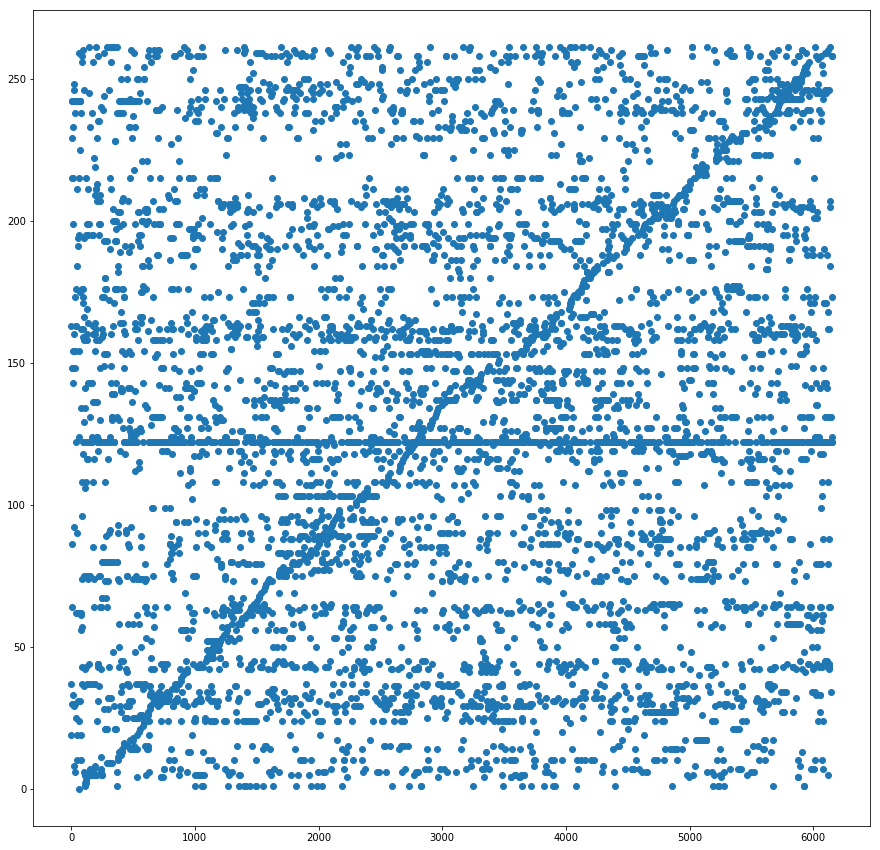

In [82]:
plt.figure(figsize =[15,15])
plt.scatter([i for i in range(len(df['AffinityPropagation']))],df['AffinityPropagation'])

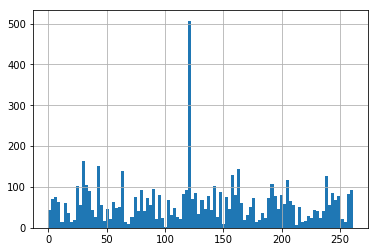

In [83]:
df['AffinityPropagation'].hist(bins =100)